In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_data = pd.read_csv("/Users/mac/Desktop/IDX Exchange/Dataset/complete_cleaned_data2.csv")
all_data = all_data.dropna()


In [33]:
numeric_cols = ['Latitude', 'Longitude', 'LivingArea', 'ParkingTotal', 'BathroomsTotalInteger','BedroomsTotal', 'Stories', 'GarageSpaces',
                  'LotSizeSquareFeet','SalesTaxRate','UnemploymentRate','CPI','MortgageRate30Fixed','FedInterestRate','Age','LotDensity']
ranges = all_data[numeric_cols].max() - all_data[numeric_cols].min()
print(ranges.sort_values(ascending=False))
sd_cols = ['LotSizeSquareFeet','LivingArea','LotDensity','Age']

LotSizeSquareFeet        215753.000000
LivingArea                 4395.000000
ParkingTotal                775.000000
LotDensity                  261.490127
Age                         225.000000
Latitude                     10.014066
Longitude                     9.405844
CPI                           5.860000
BathroomsTotalInteger         5.000000
BedroomsTotal                 4.000000
GarageSpaces                  4.000000
Stories                       1.000000
MortgageRate30Fixed           0.310000
UnemploymentRate              0.200000
FedInterestRate               0.150000
SalesTaxRate                  0.040000
dtype: float64


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Select features and target variable
X = all_data.drop(columns=['ClosePrice'])
y = all_data['ClosePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Suppose X_train and X_test are your feature DataFrames, and
# numerical_cols is the list of columns to standardize.

scaler = StandardScaler()

# Fit on training data
scaler.fit(X_train[sd_cols])

# Transform training and test
X_train_scaled = X_train.copy()
X_train_scaled[sd_cols] = scaler.transform(X_train[sd_cols])

X_test_scaled = X_test.copy()
X_test_scaled[sd_cols] = scaler.transform(X_test[sd_cols])

In [40]:
# Model 3: xgboost model
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=900,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape_fraction = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:,.2f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fraction}")

Mean Squared Error: 59,753,974,065.55
RMSE: $244,446
R² Score: 0.8801
Mean Absolute Percentage Error (MAPE): 0.1144227216152


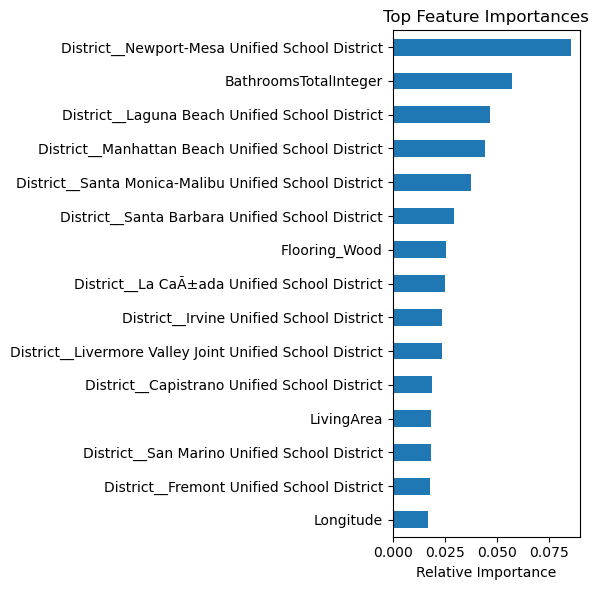

In [41]:
# Build a Series indexed by feature name:
feature_names = X_train.columns.tolist()
fi = pd.Series(xgb_model.feature_importances_, index=feature_names)

# Show only the top N features
top_n = 15  # You can change this number as needed
fi_top = fi.sort_values(ascending=False).head(top_n).sort_values(ascending=True)

# Sort and plot:
fi_top.plot.barh(figsize=(6, top_n * 0.4))
plt.title("Top Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

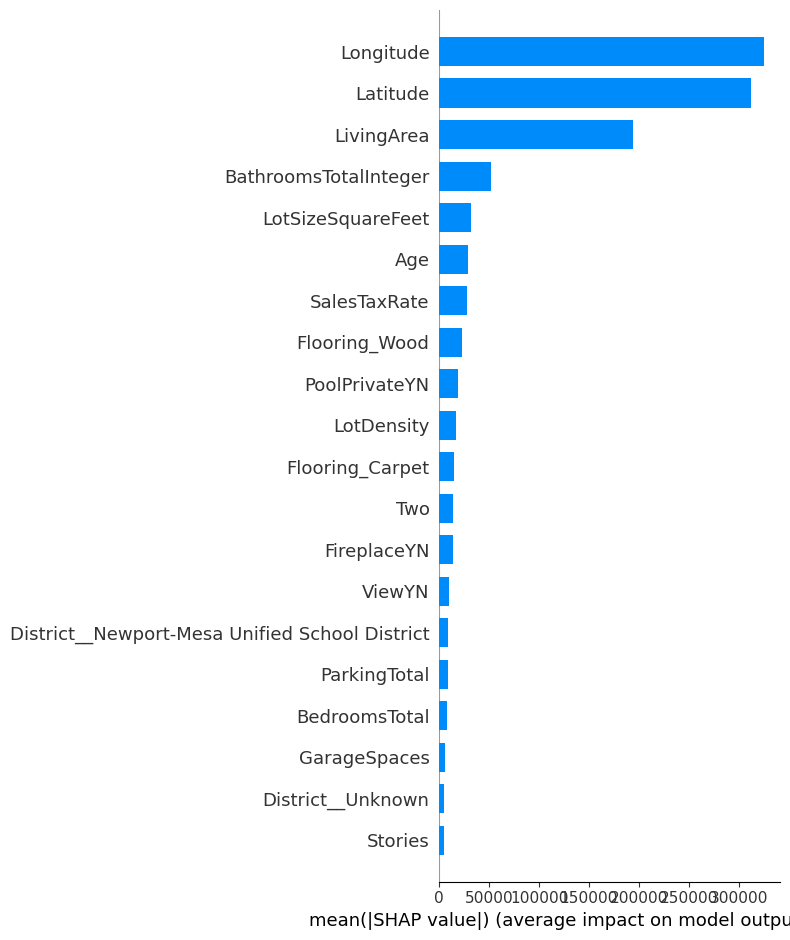

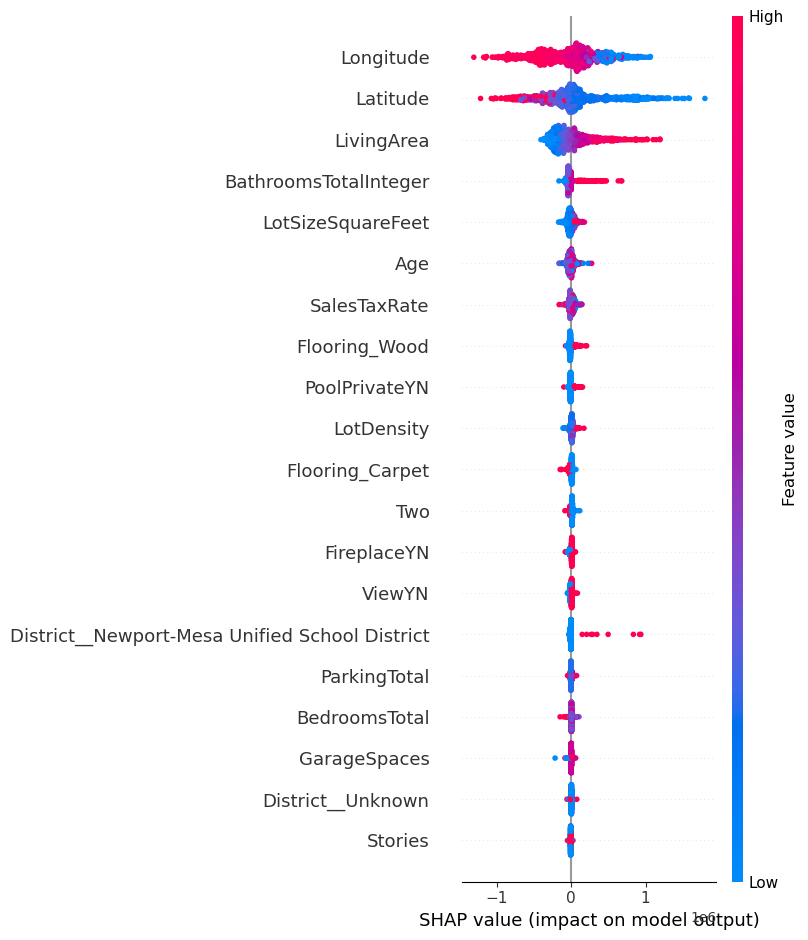

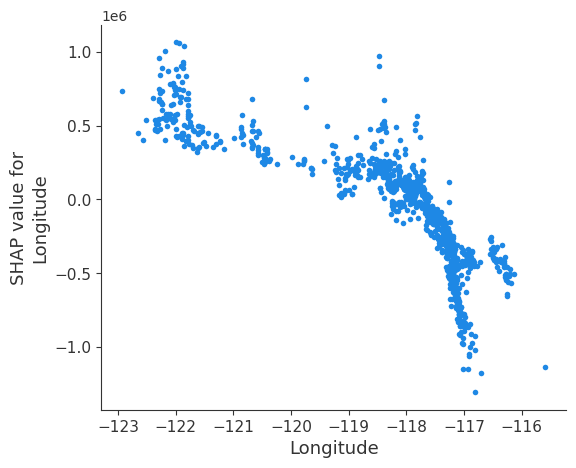

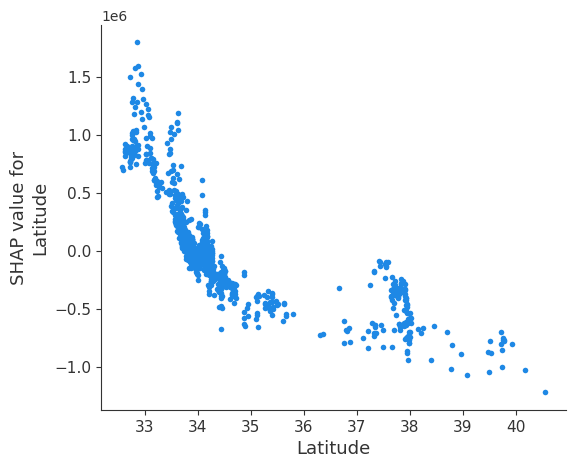

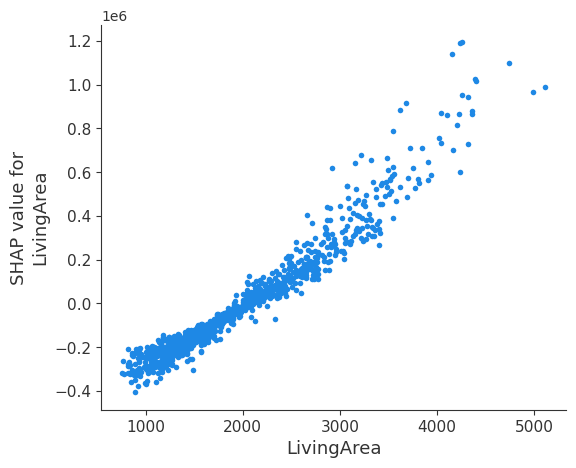

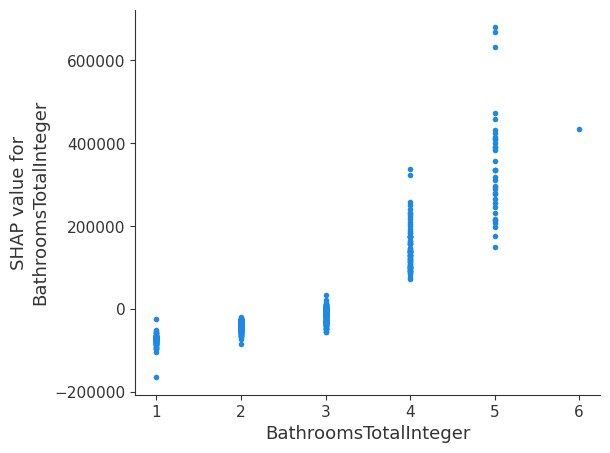

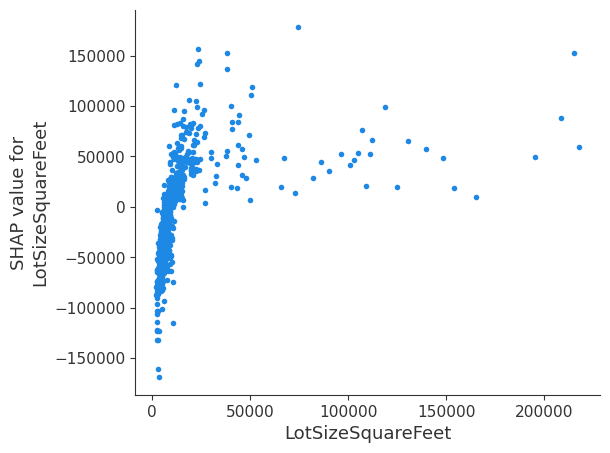

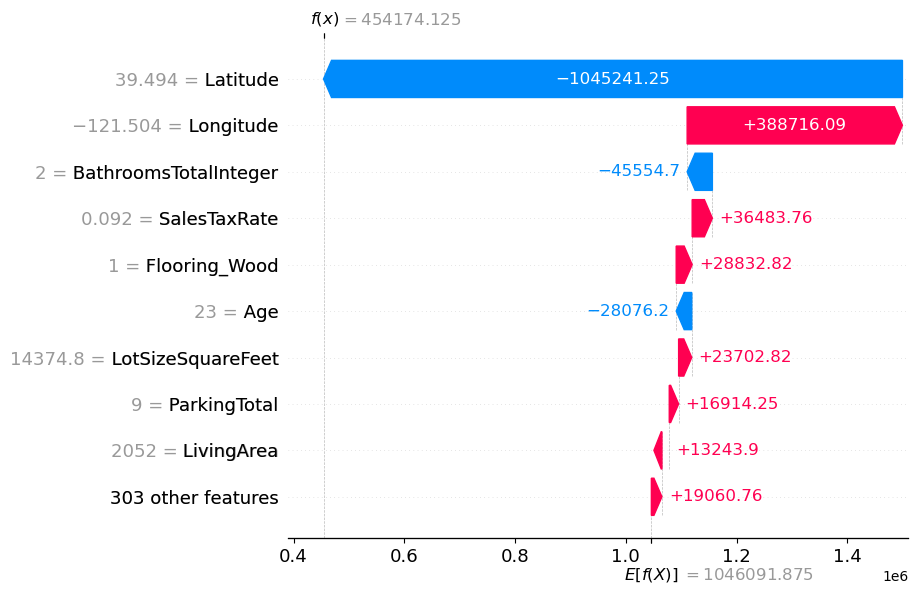

In [46]:
import shap 
# Use the held-out set for explanations
X_for_shap = X_test.copy()  # must have same columns/order as during training

# Optional: sample for faster plots if X_test is large
X_sample = X_for_shap.sample(n=min(1000, len(X_for_shap)), random_state=42)

# Build a SHAP explainer for tree models
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values (new & old API compatibility)
shap_out = explainer(X_sample)
try:
    shap_values = shap_out.values        # new API object
    base_value = shap_out.base_values.mean()
except AttributeError:
    shap_values = explainer.shap_values(X_sample)  # old API returns ndarray
    base_value = explainer.expected_value
# Bar chart: mean(|SHAP|) per feature (global importance)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# Beeswarm: direction & magnitude of impact per feature across samples
shap.summary_plot(shap_values, X_sample, show=True)

# Identify top features by average absolute SHAP
mean_abs = np.abs(shap_values).mean(axis=0)
top_feats = X_sample.columns[np.argsort(mean_abs)[-10:]][::-1]  # top 10

# Plot a few key ones (change feature names if you want specific ones)
for f in top_feats[:5]:
    shap.dependence_plot(f, shap_values, X_sample, interaction_index=None)  # add interaction_index=f2 to see 2-way

# Pick one row to explain
i = 0  # or X_sample.index[0]
row = X_sample.iloc[[i]]

row_expl = explainer(row)
try:
    shap.plots.waterfall(row_expl[0])    # new API
except Exception:
    # Fallback for older API
    shap.force_plot(base_value, shap_values[i,:], row, matplotlib=True)


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

scoring = {
    "r2": "r2",
    "mape": "neg_mean_absolute_percentage_error"
}

grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid={
        "n_estimators": [600,700,800,900],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [6,8,10]
    },
    scoring=scoring,
    refit="r2",          # <-- pick the model with the highest R²
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X, y)

print("Best params by R²:", grid_search.best_params_)
best_index = grid_search.best_index_
print(f"Best CV R²: {grid_search.cv_results_['mean_test_r2'][best_index]:.4f}")
print(f"CV MAPE at that point: {-100*grid_search.cv_results_['mean_test_mape'][best_index]:.2f}%")


Best params by R²: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 900}
Best CV R²: 0.8832
CV MAPE at that point: 11.62%
